# Image-and-text section of sandbox for 'Semantics and Deep Learning' (Draft)

**by Lisa Bylinina**



In [ ]:
#@title Installing and cloning useful stuff, disregard
!pip install transformers
!rm -fr SemDL
!git clone -b multimodal https://github.com/kovvalsky/SemDL.git

Cloning into 'SemDL'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 58 (delta 11), reused 27 (delta 2), pack-reused 0
Receiving objects: 100% (58/58), 449.83 KiB | 13.23 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [ ]:
#@title Some imports..
from SemDL.multimodal import load_clip, embed_text, embed_local_image, embed_image_from_url
import torch
import numpy as np

In [ ]:
#@title Loading CLIP: We choose a particular model from Huggingface to play with
model, tokenizer, processor = load_clip("openai/clip-vit-base-patch32")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Here is the picture we will be looking at now:


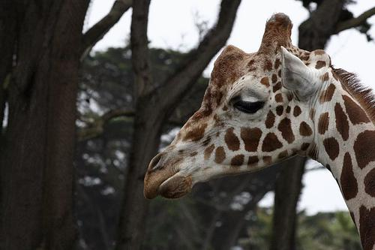


Sanity check -- vector sizes are correct and the same for image and text: torch.Size([512]) torch.Size([512])

..and the winner is: GIRAFFE


In [ ]:
#@title Embedding images and texts

#@markdown Choose one of the three pre-loaded images:
image = '/content/SemDL/data/v7w_2381480.jpg' #@param ["/content/SemDL/data/v7w_2413440.jpg", "/content/SemDL/data/v7w_2389720.jpg", "/content/SemDL/data/v7w_2381480.jpg"]

#@markdown CLIP can associate images and texts with vectors in the same shared space. The closer things land in that space, the better they 'match'. If we want to see which of the several texts is a better match to the image, we can pair each of the text vectors with the image vector and see which pair\'s dot product is higher (= vectors are more aligned). Let's try!

#@markdown Three textual descriptions we will check against this image:
text_1 = 'elephant' #@param {type:"string"}
text_2 = 'giraffe' #@param {type:"string"}
text_3 = 'person' #@param {type:"string"}

#@markdown P.S. Feel free to edit these text fields in any way you like and run this cell again to see what happens.

print('Here is the picture we will be looking at now:')
image_vector = embed_local_image(image, processor, model)
text_options = [text_1, text_2, text_3]
text_vectors = [embed_text(x, tokenizer, model) for x in text_options]

print('\nSanity check -- vector sizes are correct and the same for image and text:', image_vector.shape, text_vectors[0].shape)

answer = np.argmax([torch.dot(x, image_vector).item() for x in text_vectors])
print('\n..and the winner is:', text_options[answer].upper())

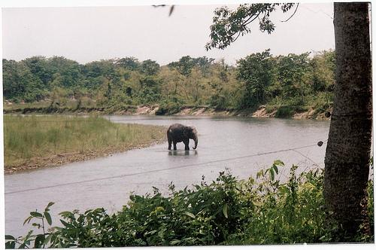


The winning description: THIS IS AN ELEPHANT.

Comparing negated description to a description that is correct but too general..

Here is the winner: THIS IS NOT AN ELEPHANT.


In [ ]:
#@title A slightly trickier case: An elephant, not-an-elephant, an animal?

#@markdown Let's focus on one particular picture for a moment: the elephant. Thinking in terms of truthful description, two of the following three descriptions are correct and one is not. 'This is an elephant' and 'This is an animal' are true of the picture, but the latter sounds a bit too general -- would anybody really describe a picture of an elephant like this? 'This is not an elephant' is simply false. So, the last two texts are not so great for this image -- but in different ways. Let's see how this plays out.
image = '/content/SemDL/data/v7w_2413440.jpg'

image_vector = embed_local_image(image, processor, model)

basic = 'This is an elephant.' #@param {type:"string"}
negated = 'This is not an elephant.' #@param {type:"string"}
too_general = 'This is an animal.' #@param {type:"string"}

#@markdown As before, feel free to modify the texts in any way you like.

text_options = [basic, negated, too_general]
text_vectors = [embed_text(x, tokenizer, model) for x in text_options]

answer = np.argmax([torch.dot(x, image_vector).item() for x in text_vectors])
print('\nThe winning description:', text_options[answer].upper())
print('\nComparing negated description to a description that is correct but too general..')

answer = np.argmax([torch.dot(x, image_vector).item() for x in text_vectors[1:]])

print('\nHere is the winner:', text_options[answer+1].upper())

CANDIDATES:
a photo of 1 cat
a photo of 2 cats
a photo of 3 cats
a photo of 4 cats
a photo of 5 cats
a photo of 6 cats
a photo of 10 cats
a photo of 25 cats
a photo of 100 cats

Here is the picture of cat(s)!


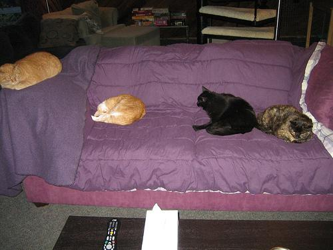

...aand the predicted number of cats is: 4


In [ ]:
#@title But can it count cats?

#@markdown Here is what we will do now. We have pre-loaded some images of different quantities of cats! Let's pick one image, by the number of cats in the picture.

#@markdown Choose how many cats you want the image to have:

n_of_cats = 4 #@param {type:"slider", min:1, max:5, step:1}

#@markdown Let's define the texts that we will locate against the image embedding. You can change the pattern to see if the results end up robust about some minor changes (consider 'a picture of..', 'the picture shows..' and so on). '[N cat(s)]' will be replaced with '1 cat' and '2 cats' and up when a bunch of candidate texts will be created iteratively.

text_pattern = 'a photo of [N cat(s)]' #@param {type:"string"}

#@markdown Will the version of the description with the right numeral win over the rest?

one, many = '1 cat', 'N cats'
candidates = [text_pattern.replace('[N cat(s)]', one) if x==1 \
              else text_pattern.replace('[N cat(s)]', many).replace('N', str(x)) \
              for x in list(range(1,7))+[10, 25, 100]]

print('CANDIDATES:')
print('\n'.join(candidates))

cats = ['/content/SemDL/data/coco_cat.jpeg',
        '/content/SemDL/data/v7w_2_cats.jpg',
        '/content/SemDL/data/coco_3_cats.jpeg',
        '/content/SemDL/data/v7w_4_cats.jpg',
        '/content/SemDL/data/coco_5_cats.jpeg']

image = cats[n_of_cats-1]

print('\nHere is the picture of cat(s)!')
image_vector = embed_local_image(image, processor, model)
text_vectors = [embed_text(x, tokenizer, model) for x in candidates]

answer = np.argmax([torch.dot(x, image_vector).item() for x in text_vectors])+1
print('...aand the predicted number of cats is:', answer)

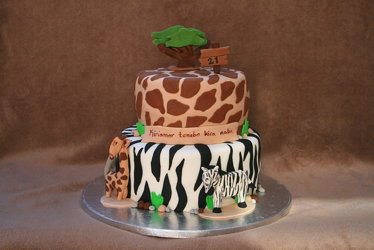

The winner: CAKE


In [ ]:
#@title Try different image and text combinations

#@markdown Paste an image URL:
image_URL = 'https://farm4.staticflickr.com/3771/8750708926_730d5de79c_z.jpg' #@param {type:"string"}

#@markdown Two texts to contrast for this image:
text_1 = 'zebra' #@param {type:"string"}
text_2 = 'cake' #@param {type:"string"}

texts = [text_1, text_2]
image_vector = embed_image_from_url(image_URL, processor, model)

text_vectors = [embed_text(x, tokenizer, model) for x in texts]
answer = np.argmax([torch.dot(x, image_vector).item() for x in text_vectors])
print('The winner:', texts[answer].upper())